In [1]:
# Celda de notebook
import os, sqlite3
from builddb import BuildDB
from audio_loader import load_audio
from generator import Generator
import unicodedata, re

db_path = 'shazam.db'

In [2]:

if os.path.exists(db_path): os.remove(db_path)

builder = BuildDB(db_path)
fg = Generator(sr=44100)

for lib in ['library1','library2']:
    for root, _, files in os.walk(lib):
        for fname in files:
            if not fname.lower().endswith('.wav'):
                continue

            raw_key = os.path.splitext(fname)[0]
            track_key = builder.normalize_key(raw_key)

            y = load_audio(os.path.join(root, fname), target_sr=44100)
            freqs, times, Sxx = fg.compute_spectrogram(y)
            peaks = fg.get_peaks(Sxx, times, freqs)
            rows = [(h, track_key, t) for h, t in fg.generate_hashes(peaks)]
            builder.add_batch(rows)  


In [3]:
import sqlite3
conn = sqlite3.connect(db_path)
cur = conn.cursor()
cur.execute("SELECT COUNT(DISTINCT track) FROM fingerprints")
print("Pistas en DB:", cur.fetchone()[0])
cur.execute("SELECT COUNT(*) FROM fingerprints")
print("Total de hashes:",    cur.fetchone()[0])
conn.close()


Pistas en DB: 40
Total de hashes: 65739


In [4]:
import os

# 1) Mapea cada carpeta de muestras a su categoría
dir_map = {
    'clean_samples'            : 'clean',
    'filtered_samples'         : 'filtered',
    'noisy_samples'            : 'noise',
    'noisy_filtered_samples'   : 'noise_filtered',
    'ambient_noise'            : 'ambient',
}

# 2) Recorre las carpetas y construye la lista de samples
samples = []
for folder, category in dir_map.items():
    for root, _, files in os.walk(folder):
        for fname in files:
            if not fname.lower().endswith('.wav'):
                continue
            path = os.path.join(root, fname)
            # Extrae la etiqueta real: parte antes del último "_"
            base = os.path.splitext(fname)[0]
            true_label = base.rsplit('_', 1)[0]
            samples.append((path, true_label, category))



In [5]:
import shutil, os
# Borra la carpeta .hashcache sin errores si no existe
try:
    shutil.rmtree('.hashcache')
    print("Cache eliminado: .hashcache")
except FileNotFoundError:
    print("No hay cache para borrar.")

Cache eliminado: .hashcache


In [6]:
# Helper to normalize labels
def normalize_label(s: str) -> str:
    s = unicodedata.normalize('NFKD', s.lower())
    s = re.sub(r'[^a-z0-9_]+', '_', s)
    return re.sub(r'_+', '_', s).strip('_')


In [7]:
import os
import pandas as pd
from parallel_utils import warmup_cache, batch_recognize_fast
from sklearn.metrics import classification_report, confusion_matrix


warmup_cache(samples, db_path, n_workers=os.cpu_count())

# 3) Ejecuta reconocimiento en paralelo y llena results
results = list(batch_recognize_fast(samples, db_path, n_workers=os.cpu_count()))

df = pd.DataFrame(results, columns=['true','pred','category'])
df['true_n'] = df['true'].apply(normalize_label)
df['pred_n'] = df['pred'].apply(normalize_label)
df['correct'] = df['true_n'] == df['pred_n']

# 2) Accuracy global
overall_acc = df['correct'].mean()
print(f"Overall accuracy: {overall_acc:.2%}")

# 3) Accuracy por categoría
acc_by_cat = df.groupby('category')['correct'].mean()
print("\nAccuracy by category:")
print(acc_by_cat.apply(lambda x: f"{x:.2%}"))

# 4) (Opcional) Reporte de clasificación completo
print("\nClassification report:")
print(classification_report(df['true_n'], df['pred_n']))


Overall accuracy: 85.64%

Accuracy by category:
category
ambient            0.00%
clean             99.00%
filtered          97.00%
noise             74.50%
noise_filtered    75.50%
Name: correct, dtype: object

Classification report:
                                           precision    recall  f1-score   support

                              01_bourgade       0.70      0.95      0.81        20
                        02_for_the_better       0.72      0.90      0.80        20
                            03_progressed       0.64      0.90      0.75        20
                       04_arcade_playroom       0.81      0.85      0.83        20
                                   05_sea       0.71      1.00      0.83        20
                      06_over_the_horizon       1.00      1.00      1.00        20
                           07_true_routes       0.94      0.85      0.89        20
                                     08_d       0.86      0.90      0.88        20
                 

/Users/beatrizenriquez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/beatrizenriquez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/beatrizenriquez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

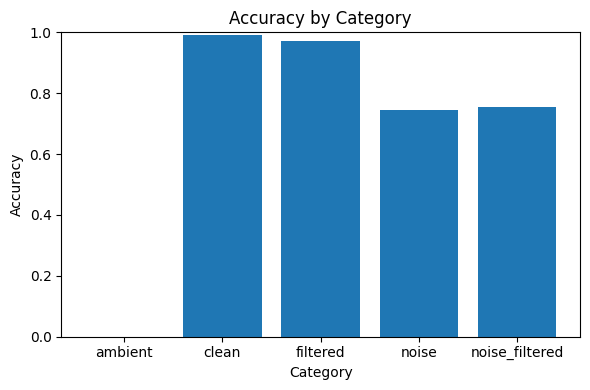

In [8]:
import os
import pickle
import unicodedata
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from inmemory_recognizer import InMemoryRecognizer

# Reconstruct DataFrame of full results (assumes `results` and `samples` in scope)
df = pd.DataFrame(results, columns=['true','pred','category'])
df['true_n'] = df['true'].apply(normalize_label)
df['pred_n'] = df['pred'].apply(normalize_label)
df['correct'] = (df['true_n'] == df['pred_n']).astype(int)

# Bar chart: Accuracy by Category (All Samples)
accuracy_all = df.groupby('category')['correct'].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(accuracy_all['category'], accuracy_all['correct'])
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.title('Accuracy by Category')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()




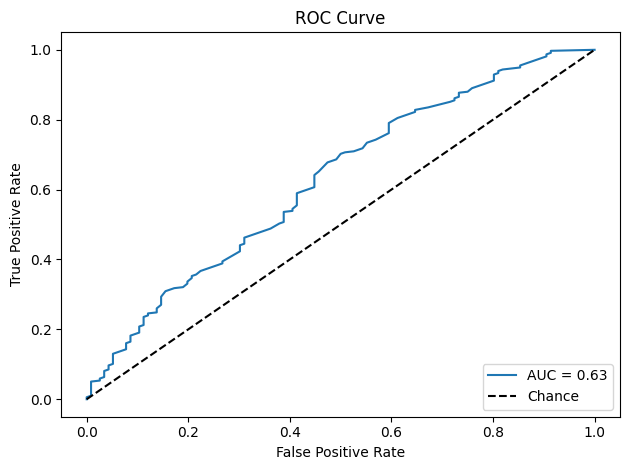

In [9]:

# 4) Calculamos el score *para la etiqueta real* usando el cache
rec = InMemoryRecognizer(db_path=db_path)

scores = []
for idx, row in df.iterrows():
    # path y etiqueta real
    path      = samples[idx][0]
    true_lbl  = row['true_n']
    # localiza el pickle cache de hashes
    base = os.path.basename(path)
    cache_file = os.path.join('.hashcache', base + '.pkl')
    tbl = pickle.load(open(cache_file,'rb'))  # dict hash -> [times]
    # contamos solo los hashes que matchean contra la pista real
    cnt = 0
    for h, times in tbl.items():
        # entries = list of (track,time)
        for track, _ in rec.hash_index.get(h, []):
            if normalize_label(track) == true_lbl:
                cnt += len(times)
    scores.append(cnt)

df['score'] = scores

# 5) ROC y AUC
y_true  = df['correct']
y_score = df['score']

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# 6) Dibuja la curva ROC
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


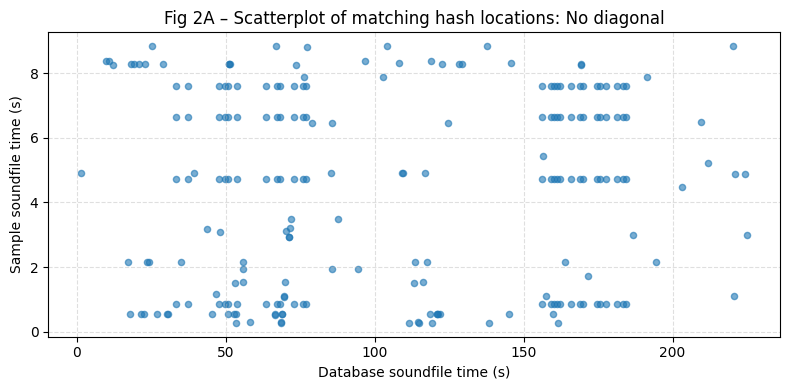

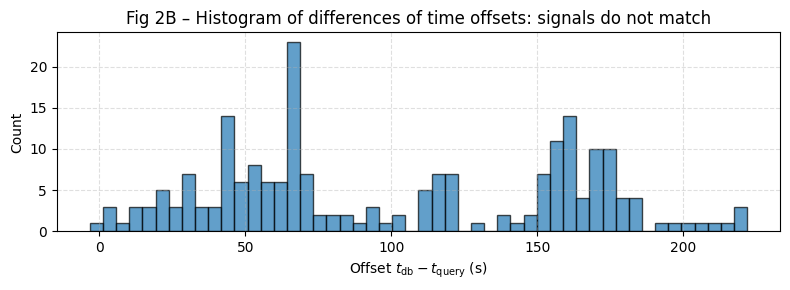

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ← adjust these imports to your actual module names
from generator import Generator
from audio_loader import load_audio

def plot_nonmatch_plots(query_wav, db_wav, sr=44100):
    """
    For two non‐matching WAV files, compute all matching hash pairs
    and plot:
      • Fig 2A: scatter of (t_db, t_query)  
      • Fig 2B: histogram of (t_db − t_query)
    """
    fg = Generator(sr=sr)

    # 1) Fingerprint the query sample
    yq = load_audio(query_wav, target_sr=sr)
    fq, tq, Sxx_q = fg.compute_spectrogram(yq)
    peaks_q     = fg.get_peaks(Sxx_q, tq, fq)
    hashes_q    = list(fg.generate_hashes(peaks_q))

    # 2) Fingerprint the database track
    yd = load_audio(db_wav, target_sr=sr)
    fd, td, Sxx_d = fg.compute_spectrogram(yd)
    peaks_d     = fg.get_peaks(Sxx_d, td, fd)
    hashes_d    = list(fg.generate_hashes(peaks_d))

    # 3) Build a map hash → times
    tq_map = {}
    for h, t in hashes_q:
        tq_map.setdefault(h, []).append(t)
    td_map = {}
    for h, t in hashes_d:
        td_map.setdefault(h, []).append(t)

    # 4) Collect all matching (t_query, t_db) pairs
    t_query_list, t_db_list, dt_list = [], [], []
    for h, times_q in tq_map.items():
        times_d = td_map.get(h, [])
        for tq in times_q:
            for td in times_d:
                t_query_list.append(tq)
                t_db_list.append(td)
                dt_list.append(td - tq)

    t_query_arr = np.array(t_query_list)
    t_db_arr    = np.array(t_db_list)
    dt_arr      = np.array(dt_list)

    # --- Fig 2A: scatterplot ---
    plt.figure(figsize=(8,4))
    plt.scatter(t_db_arr, t_query_arr, s=20, alpha=0.6)
    plt.xlabel('Database soundfile time (s)')
    plt.ylabel('Sample soundfile time (s)')
    plt.title('Fig 2A – Scatterplot of matching hash locations: No diagonal')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()

    # --- Fig 2B: histogram of offsets ---
    plt.figure(figsize=(8,3))
    plt.hist(dt_arr, bins=50, edgecolor='k', alpha=0.7)
    plt.xlabel(r'Offset $t_\mathrm{db} - t_\mathrm{query}$ (s)')
    plt.ylabel('Count')
    plt.title('Fig 2B – Histogram of differences of time offsets: signals do not match')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()

    plt.show()

# Example call: replace with your actual paths
plot_nonmatch_plots(
    query_wav = 'noisy_samples/01_Bourgade_samples_noisy/01_Bourgade_2.wav',
    db_wav    = 'library1/01. Bourgade.wav'
)


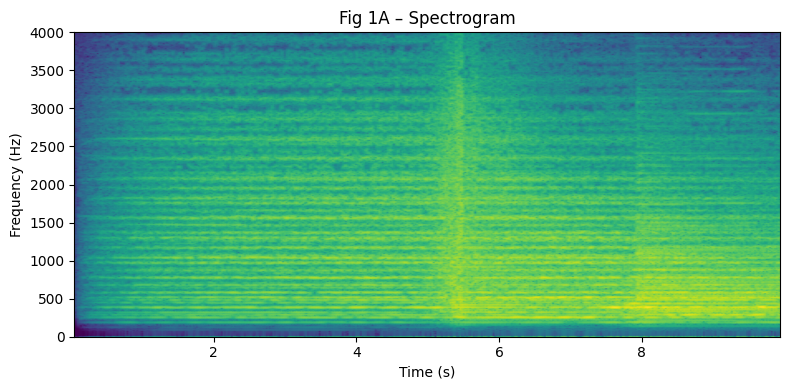

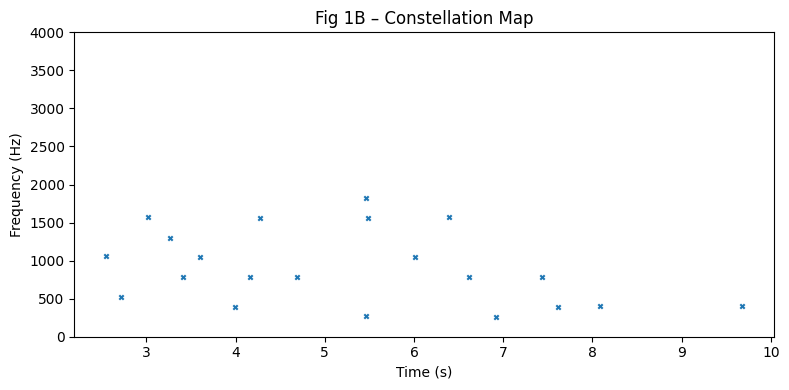

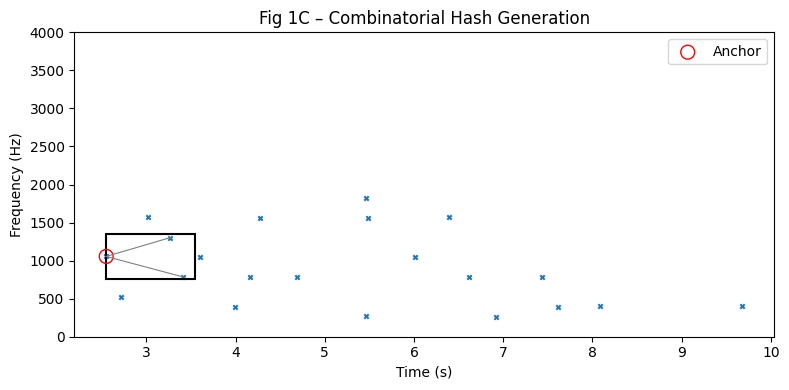

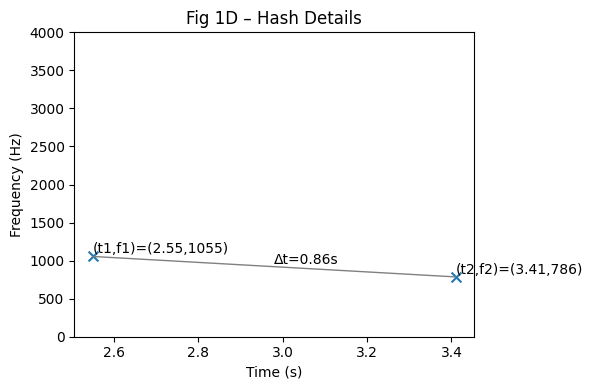

In [11]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from generator import Generator
from audio_loader import load_audio

# 1) Asegúrate de que tu carpeta de proyecto está en PYTHONPATH
if '' not in sys.path:
    sys.path.insert(0, '')

# Temporary generator with smaller settings
fg_small = Generator(sr=22050, n_fft=2048, hop_length=512,
                                fan_value=2, max_peaks=5,
                                amp_min_db=None, zone_time=1.0, zone_freq=600)



audio_path = 'library1/06. Over the Horizon.wav'
y = load_audio(audio_path, target_sr=44100)

# 3) Espectrograma y detección de picos
y10 = y[:22050*10]                        # first 10 seconds
freqs, times, Sxx = fg_small.compute_spectrogram(y10)
peaks = fg_small.get_peaks(Sxx, times, freqs)
# peaks.shape == (N,4): [t_idx, f_idx, t_cs, f_hz]
t_vals = peaks[:,2] / 100.0   # tiempo en s
f_vals = peaks[:,3]           # frecuencia en Hz

# --- Fig 1A: Spectrogram ---
plt.figure(figsize=(8,4))
plt.pcolormesh(times, freqs, Sxx, shading='gouraud')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Fig 1A – Spectrogram')
plt.ylim(0, 4000)
plt.tight_layout()

# --- Fig 1B: Constellation Map ---
plt.figure(figsize=(8,4))
plt.scatter(t_vals, f_vals, marker='x', s=10)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Fig 1B – Constellation Map')
plt.ylim(0, 4000)
plt.tight_layout()

# --- Fig 1C: Combinatorial Hash Generation ---
anchor_t, anchor_f = t_vals[0], f_vals[0]
rect = plt.Rectangle((anchor_t, anchor_f - fg_small.zone_freq/2),
                     fg_small.zone_time, fg_small.zone_freq,
                     edgecolor='black', facecolor='none', linewidth=1.5)
in_zone = [(t,f) for t,f in zip(t_vals, f_vals)
           if 0 < (t-anchor_t) <= fg_small.zone_time
           and abs(f-anchor_f) <= fg_small.zone_freq/2]

plt.figure(figsize=(8,4))
plt.scatter(t_vals, f_vals, marker='x', s=10)
plt.gca().add_patch(rect)
for t2,f2 in in_zone:
    plt.plot([anchor_t,t2], [anchor_f,f2], 'gray', linewidth=0.8)
plt.scatter([anchor_t], [anchor_f], facecolor='none',
            edgecolor='red', s=100, label='Anchor')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Fig 1C – Combinatorial Hash Generation')
plt.legend()
plt.ylim(0, 4000)
plt.tight_layout()

# --- Fig 1D: Hash Details ---
t2, f2 = in_zone[1]  # segundo punto para detalle
dt = round(t2 - anchor_t, 2)

plt.figure(figsize=(6,4))
plt.scatter([anchor_t, t2], [anchor_f, f2], marker='x', s=50)
plt.plot([anchor_t, t2], [anchor_f, f2], 'gray', linewidth=1)
plt.text(anchor_t, anchor_f,
         f'(t1,f1)=({anchor_t:.2f},{int(anchor_f)})',
         va='bottom')
plt.text(t2, f2,
         f'(t2,f2)=({t2:.2f},{int(f2)})',
         va='bottom')
plt.text((anchor_t+t2)/2, (anchor_f+f2)/2,
         f'Δt={dt}s', va='bottom', ha='left')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Fig 1D – Hash Details')
plt.ylim(0, 4000)
plt.tight_layout()

plt.show()
